In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PyEMD import EMD

In [5]:
SAMPLING_FREQUENCY = 100

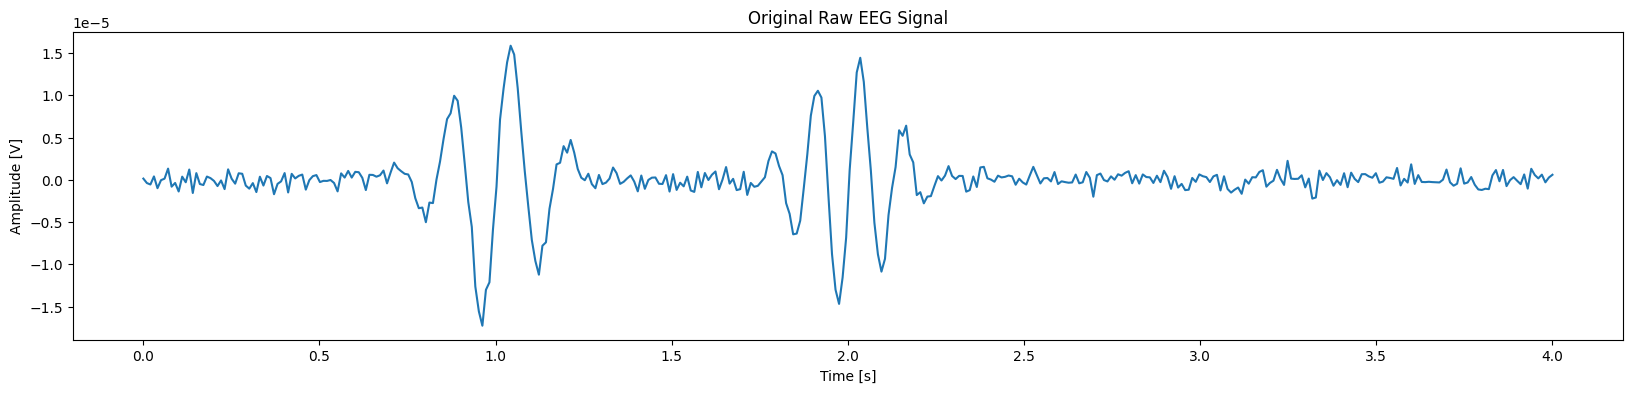

In [7]:
with open('/home/djolo/emd_on_synth_signal/Signal2_2018.csv', 'r') as eeg_csv:
    raw_signal = np.array(eeg_csv.read().strip().split(','), dtype=float)
    
time_axis = np.linspace(0, len(raw_signal)/SAMPLING_FREQUENCY, len(raw_signal))

plt.figure(figsize=(20, 4))
plt.plot(time_axis, raw_signal)
plt.xlabel("Time [s]")
plt.ylabel('Amplitude [V]')
plt.title(f"Original Raw EEG Signal")
plt.show()

Available splines

    Natural cubic (default)
    Pointwise cubic
    Hermite cubic ("cubic_hermite")
    Akima ("akima")
    PChip ("pchip")
    Linear ("linear")
    Quadratic ("quadratic")
    Slinear?? ("slinear)


Setting parameter FIXE to any positive value will fix the number of iterations for each IMF to be exactly FIXE

Parameter FIXE_H relates to the number of iterations when the proto-IMF signal fulfils IMF conditions, i.e. number of extrema and zero-crossings differ at most by one and the mean is close to zero. This means that there will be at least FIXE_H iteration per IMF.

When both FIXE and FIXE_H are 0 then other conditions are checked (Cauchy convergence (default))

extrema_detection can either be 'simple' (default) or 'parabol'

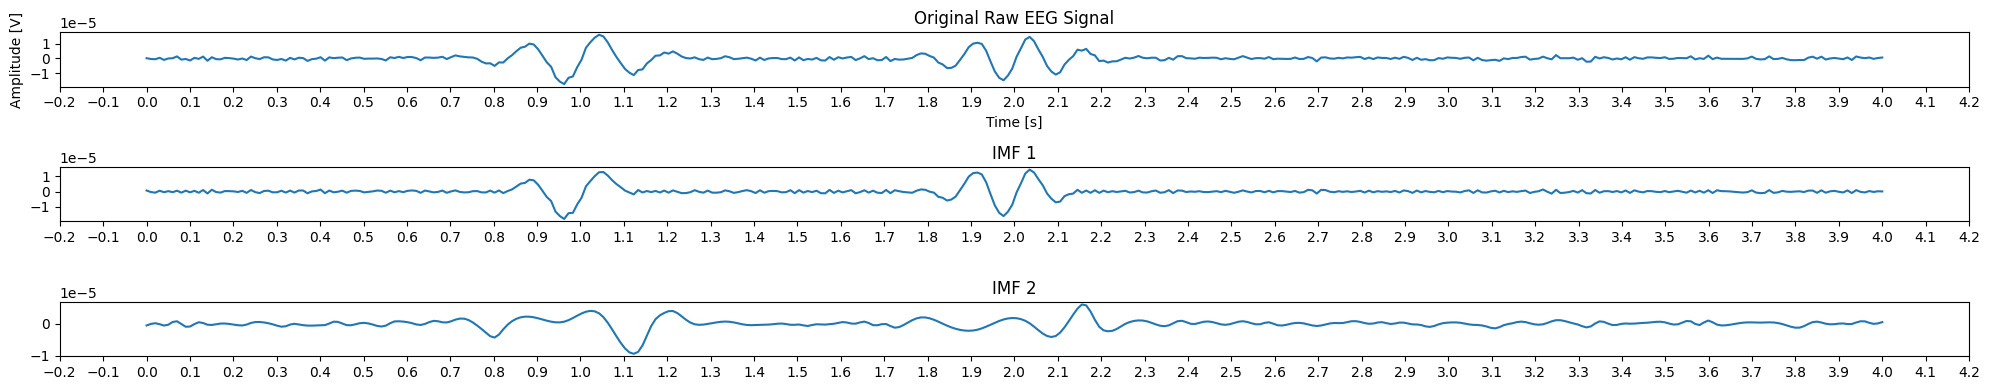

In [ ]:
emd_analyser = EMD(spline_kind='cubic',
                   extrema_detection='parabol',
                   MAX_ITERATION=1000
                   FIXE=0
                   FIXEH=0)
IMFs = emd_analyser.emd(raw_signal, time_axis)
num_imfs = IMFs.shape[0] + 1

plt.figure(figsize=(20, 4))

plt.subplot(num_imfs, 1, 1)
plt.plot(time_axis, raw_signal)
plt.xlabel("Time [s]")
plt.ylabel('Amplitude [V]')
plt.title(f"Original Raw EEG Signal")
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(0.1))

for idx, IMF in enumerate(IMFs):
    plt.subplot(num_imfs, 1, idx+2)
    plt.plot(time_axis, IMF)
    plt.title(f"IMF {idx+1}")
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(0.1))

plt.tight_layout()
plt.show()


We see quite clearly that the separation is not satisfactory. The original signal clearly has intermittency present, and the two intermittent parts are at frequencies quite close to each other, indicating that mode mixing is occurring. We can confirm this looking at the spectrum below where we have multiple peaks close together.

Text(0.5, 1.0, 'Frequency Spectrum from FFT')

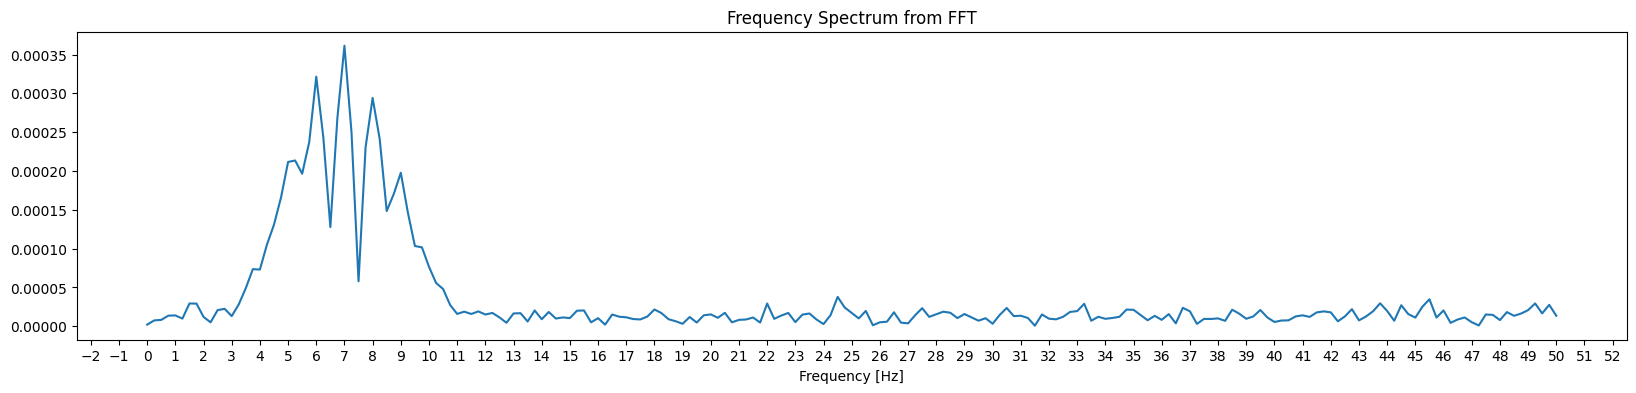

In [33]:
from matplotlib.ticker import MultipleLocator

plt.figure(figsize=(20, 4))
plt.plot(np.fft.rfftfreq(len(raw_signal), 1/SAMPLING_FREQUENCY), np.abs(np.fft.rfft(raw_signal)))

ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))

plt.xlabel("Frequency [Hz]")
plt.title("Frequency Spectrum from FFT")

# (unsuccessfully) Trying to Solve the Mode Mixing

A method is proposed in https://ntnuopen.ntnu.no/ntnu-xmlui/bitstream/handle/11250/2605131/ISGT_Mode_Mixing_New_Method_Conference_Postprint.pdf?sequence=4 to take the mode mixing into account. 

First, we will perform the Hilber transform on one of the mode-mixed IMFs, taking the first as an example.

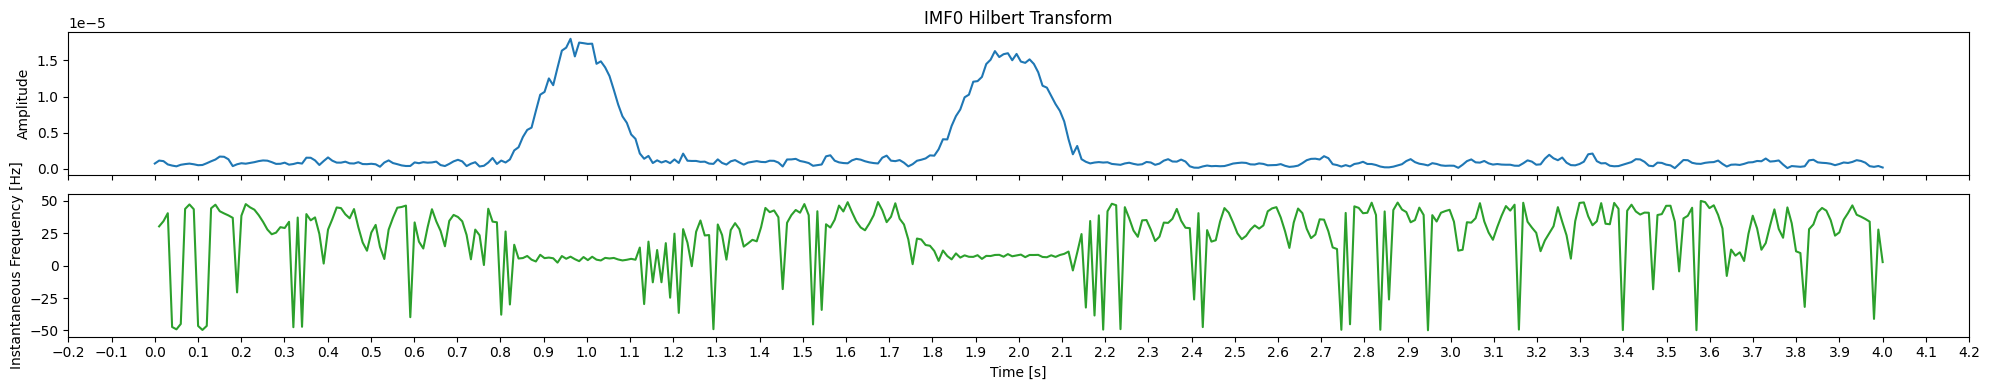

For instantaneous frequency, the maximum is 49.97107521679659, and minimum is -49.890616134569335


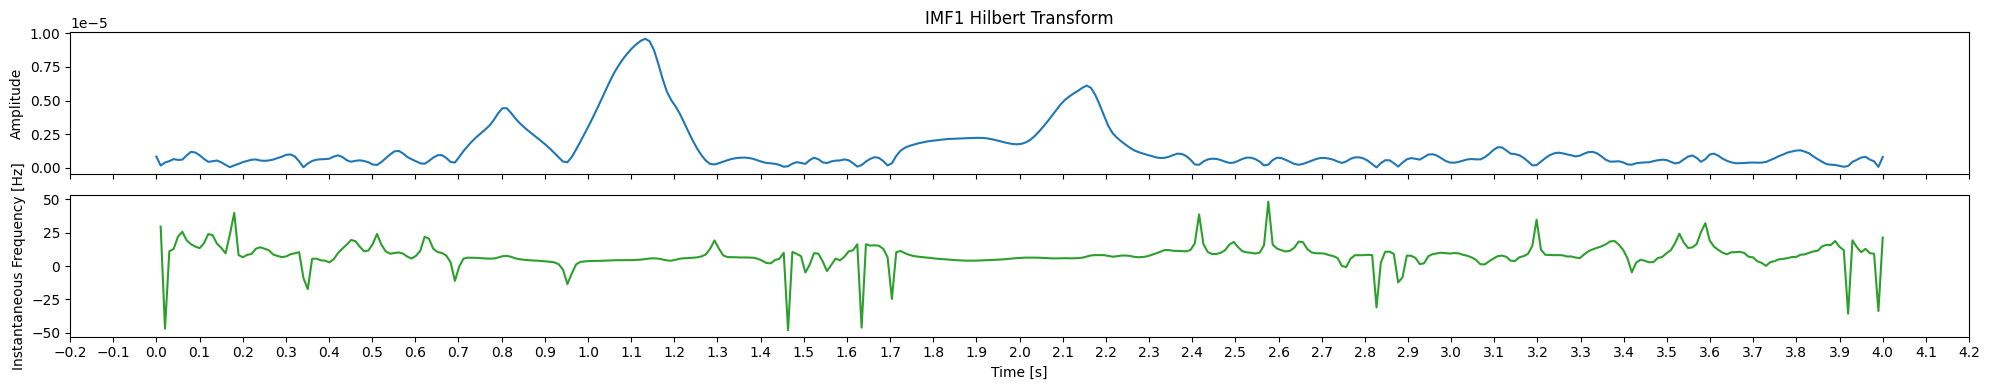

For instantaneous frequency, the maximum is 48.234716555455826, and minimum is -48.11027129510201


In [54]:
from scipy.signal import hilbert

for idx, IMF in enumerate(IMFs):
    analytic_signal = hilbert(IMF)
    instantaneous_amplitude = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))

    instantaneous_frequency = np.diff(instantaneous_phase) / (2.0*np.pi) * SAMPLING_FREQUENCY

    fig, (ax0, ax1) = plt.subplots(nrows=2, sharex='all', tight_layout=True, figsize=(20, 4))

    ax0.set_title(f"IMF{idx} Hilbert Transform")
    ax0.set_ylabel("Amplitude")
    ax0.plot(time_axis, instantaneous_amplitude)

    ax1.plot(time_axis[1:], instantaneous_frequency, 'C2-')
    ax1.set_ylabel("Instantaneous Frequency [Hz]")
    ax1.set_xlabel("Time [s]")
    
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(0.1))
    
    plt.show()


    print(f"For instantaneous frequency, the maximum is {max(instantaneous_frequency)}, and minimum is {min(instantaneous_frequency)}")

Because of the poor initial decomposition, the analytical domain gives us little new information, but from the peaks in the IMFs, we can see that the two mixed frequencies are approximately 6.67 Hz and 8.33 Hz.

We now wish to create a masking sine wave which has frequency so that 8.33/f_m > 0.7 and 6.67/f_m < 0.6, or in other words:

11.12 < f_m < 11.9

A frequency of f_m=11.2 Hz would give us 8.33/11.2 = 0.74 and 6.67/11.2 = 0.59
We also still want to stay well within the blue region for one of the components, so we will make the amplitude be so that log10(A/A_m) = -1, where A=1e-5 is the amplitude of the components. That way A_m = 1e-4

In [88]:
masking_frequency = 11.2
masking_amplitude = 1e-4
masking_signal = masking_amplitude*np.sin(2*np.pi*masking_frequency*time_axis)

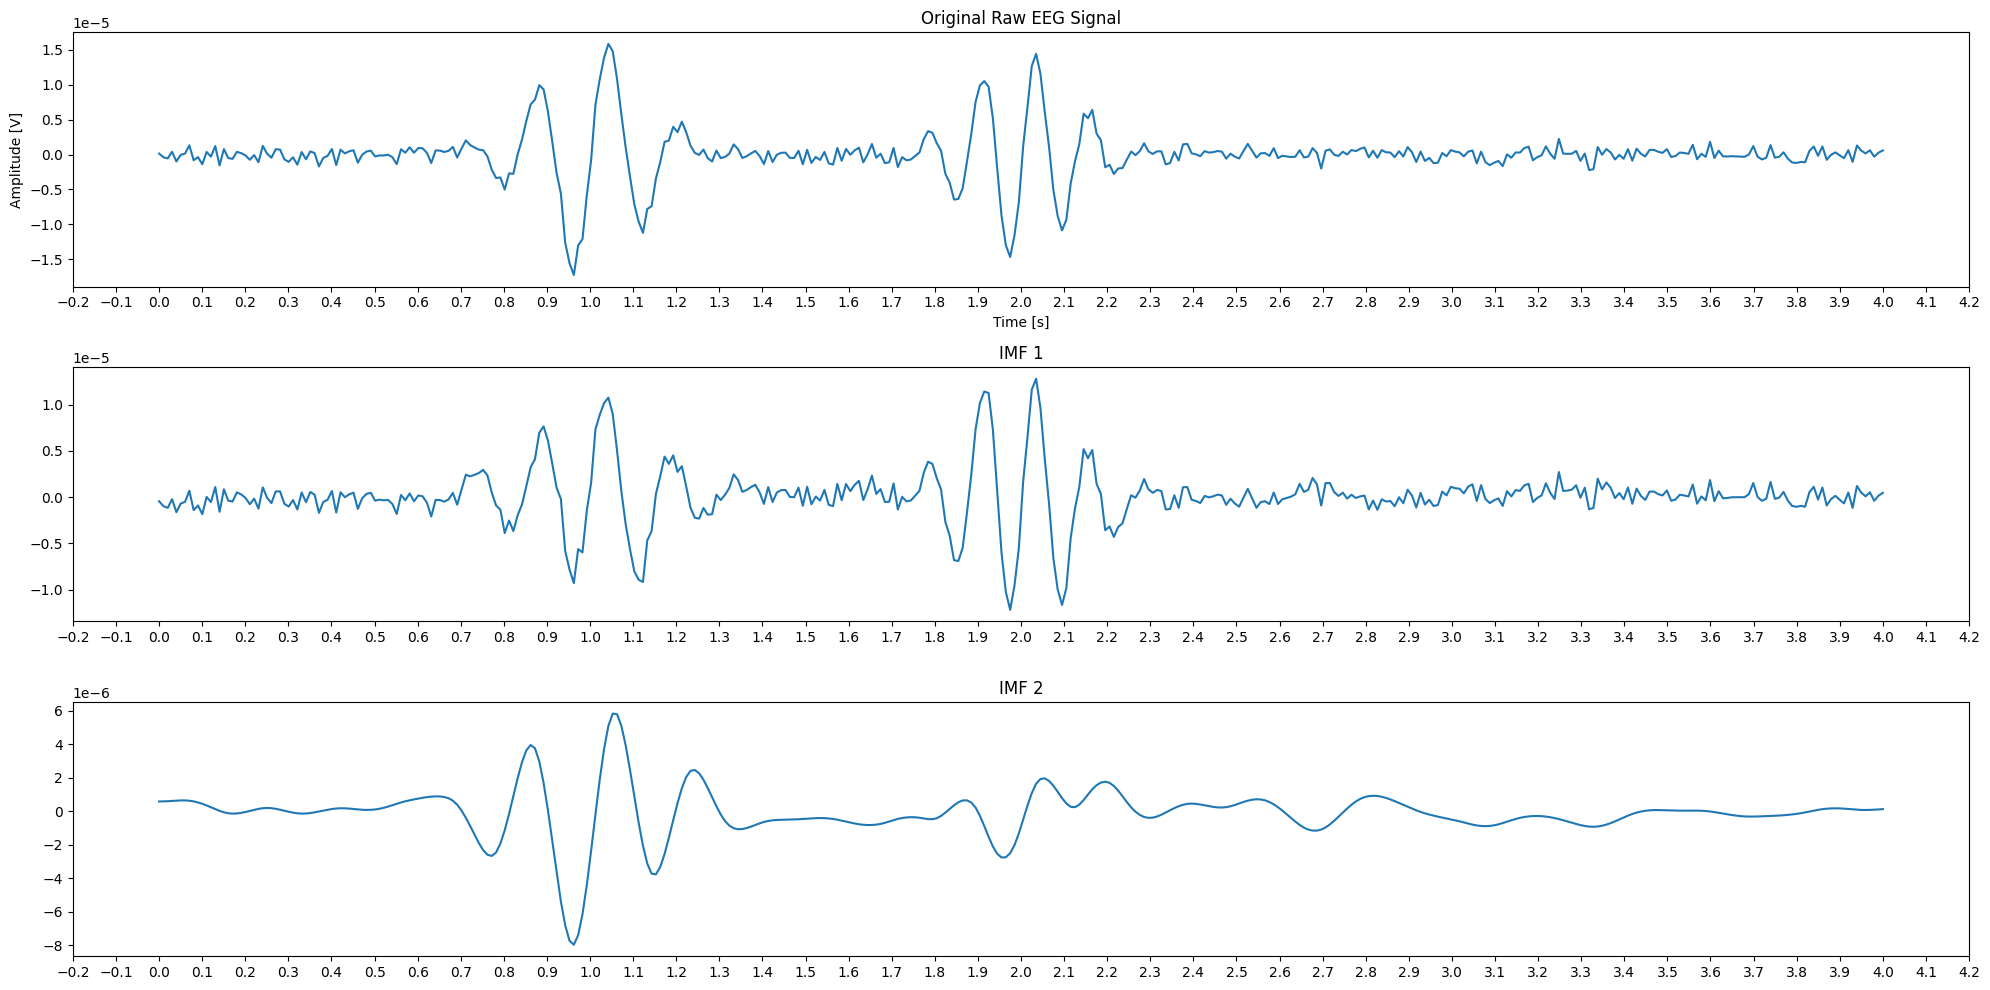

In [89]:
added_signal = raw_signal + masking_signal
subtracted_signal = raw_signal - masking_signal

added_IMFs = emd_analyser.emd(added_signal, time_axis)
subtracted_IMFs = emd_analyser.emd(subtracted_signal, time_axis)

averaged_IMFs = []

for added_IMF, subtracted_IMF in zip(added_IMFs, subtracted_IMFs):
    averaged_IMFs.append((added_IMF + subtracted_IMF) / 2)
    
plt.figure(figsize=(20, 10))
num_imfs = len(averaged_IMFs)+1
plt.subplot(num_imfs, 1, 1)
plt.plot(time_axis, raw_signal)
plt.xlabel("Time [s]")
plt.ylabel('Amplitude [V]')
plt.title(f"Original Raw EEG Signal")
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(0.1))

for idx, IMF in enumerate(averaged_IMFs):
    plt.subplot(num_imfs, 1, idx+2)
    plt.plot(time_axis, IMF)
    plt.title(f"IMF {idx+1}")
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(0.1))

plt.tight_layout()
plt.show()